In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import essay_analysis as ea
import re
from string import punctuation
from collections import OrderedDict, defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, RegexpStemmer
from sklearn.decomposition import NMF, PCA, LatentDirichletAllocation
from scipy.spatial.distance import pdist, squareform, cosine, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.misc import comb
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import seaborn as sns
import cPickle as pickle
%matplotlib inline

In [2]:
df = pd.read_csv('../data/master_essay.csv', low_memory=False)

In [3]:
df[df['essay_final'].notnull()]['top_school_final'].value_counts()

0    2126
1    1051
Name: top_school_final, dtype: int64

In [4]:
df2 = df[df['essay_final'].notnull()].copy()

In [5]:
essays = df2['essay_final'].values.copy()
essays_idx = df2['id'].values
X = essays.copy()
y = df2['top_school_final'].values

### Stop Words & Stemming/Lemmatizing

1. Let's remove ASCII characters to avoid UnicodeDecodeErrors later.
2. We should remove stop words before stemming / lemmatizing (e.g. PorterStemmer turns 'was' into 'wa')
3. Stemming is better than Lemmatizing in our case, because we don't really need to preserve contextual meanings - it's more important that we group words that mean the same thing even if they take different forms. For instance, using a PorterStemmer, if we stem 'familial' and 'family', we get the 'famili' root word in both cases. However, with a WordNetLemmatizer, the output is distinct - it returns 'familial' and 'family'. Since we will eventually build a tfidf matrix, it is preferable to use a PorterStemmer here.

In [6]:
reload(ea)
ae = ea.AnalyzeEssays()

In [7]:
ae.stopWordsAndStem(X)

essay_analysis.py:170: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  essay = ' '.join([word for word in essay.split() if word not in self.stop_words])
/Users/MikeYung/anaconda/lib/python2.7/site-packages/nltk/stem/porter.py:274: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if word[-1] == 's':


### Transform Essays into TFIDF Matrix

In [8]:
vec = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=10000)
mat = vec.fit_transform(X)

In [9]:
mat

<3177x10000 sparse matrix of type '<type 'numpy.float64'>'
	with 582653 stored elements in Compressed Sparse Row format>

### Visualizing using PCA

Goal: reduce the dimensions from 27k to 2, and visualize in a scatter plot.

In [10]:
pca = PCA(n_components=2)

In [11]:
pca.fit(mat.toarray())

PCA(copy=True, n_components=2, whiten=False)

In [12]:
mat_pca = pca.transform(mat.toarray())

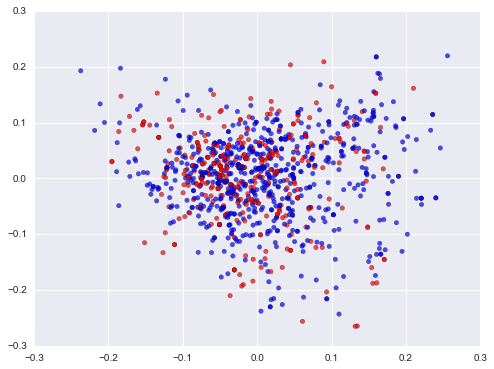

In [13]:
rand_idx = np.random.randint(0, len(X), 1000)
plt.figure(figsize=(8,6))
plt.scatter(mat_pca[rand_idx,0], mat_pca[rand_idx,1], alpha=0.7, s=20, c=y[rand_idx], cmap='bwr')

### Visualing using TSNE (t-Distributed Stochastic Neighbor Embedding)

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html <br>
Author recommends performing an inital round of dimensionality reduction first before doing TSNE. In our case, we will will NMF to reduce the data to 10 components first.

In [14]:
dr = ea.dimReduction()
mat_tsne = dr.getTSNE(NMF, 10, mat)

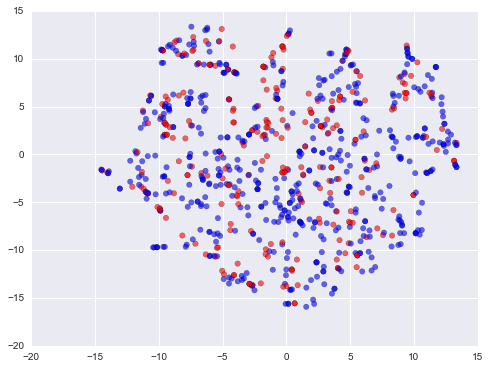

In [15]:
rand_idx = np.random.randint(0, len(X), 800)
plt.figure(figsize=(8,6))
plt.scatter(mat_tsne[rand_idx,0], mat_tsne[rand_idx,1], alpha=0.6, s=30, c=y[rand_idx], cmap='bwr')

##### If time permits, try TruncatedSVD

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

### Non-Negative Matrix Factorization (NMF)

Chose this over SVD to preserve the interpretability of positive values.

Goal: identify latent features / hidden topics across the essays. May be able to use these as features in our predictive model. We can also compute a cosine similarity matrix: the idea is so we can show most 'similar' essays.

In [16]:
reload(ea)
tm = ea.TopicModeling()

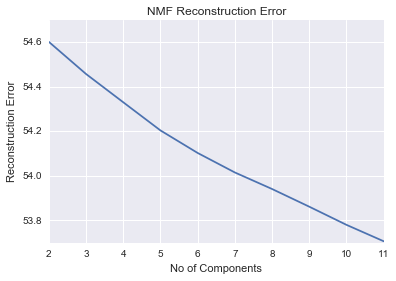

In [16]:
tm.plotOptimalNMF(mat, 12)

Doesn't look like there's any significant 'elbow' in the reconstruction error graph in the first 11 components. Any more than that and we'll likely lose the ability to 'bin'/categorize topics with similar semantic meaning.

After examining the various 'topics' generated from 2-10 topics, we heuristically decide that 7 is the best number. Let's take a look at the key words that represent each of these 7 topics.

In [17]:
nmf = NMF(n_components=7, random_state=100)
nmf.fit(mat)
H = nmf.components_
tm.showTopWords(H, vec, no_words=40)

[array([u'mother', u'father', u'famili', u'parent', u'mom', u'dad', u'life',
        u'brother', u'work', u'sister', u'home', u'live', u'family',
        u'help', u'time', u'day', u'grandmoth', u'care', u'alway', u'want',
        u'cancer', u'dream', u'hous', u'hard', u'children', u'hospit',
        u'job', u'make', u'becam', u'year', u'love', u'sibl', u'age',
        u'support', u'doctor', u'old', u'know', u'child', u'everyth',
        u'money'], 
       dtype='<U17'),
 array([u'music', u'play', u'piano', u'perform', u'song', u'band', u'danc',
        u'note', u'sing', u'stage', u'concert', u'orchestra', u'sound',
        u'guitar', u'jazz', u'piec', u'instrument', u'art', u'listen',
        u'chord', u'emot', u'musician', u'room', u'practic', u'audienc',
        u'content', u'love', u'theater', u'passion', u'feel', u'express',
        u'classic', u'audit', u'performance', u'melodi', u'violin',
        u'choir', u'everi', u'artist', u'piece'], 
       dtype='<U17'),
 array([u'cultur',

Let's now transform our tfidf matrix to get the low-dimensional (7-topic) version of it.

In [18]:
W = nmf.transform(mat)

In [22]:
# (pairwise_distances(W, metric='euclidean'))[2].argsort()[:10]

### Pickle Tfidf-Vectorizer and NMF model

In [105]:
with open('../data/vectorizer.pkl', 'w') as f:
    pickle.dump(vec, f)
with open('../data/nmf.pkl', 'w') as f:
    pickle.dump(nmf, f)

### Export data (containing just essays + topics)

To make things easier when creating an app to recommend similar essays/profiles later on, let's create a new DataFrame containing just essays, topics, and userid.

In [19]:
essays_and_topics = np.hstack((essays_idx.reshape(-1,1), (essays.reshape(-1,1))))
essays_and_topics = np.hstack((essays_and_topics, W))
df_et_cols = ['id','content','family', 'music', 'culture', 'sport', 'personal', 'science', 'career']
df_et = pd.DataFrame(essays_and_topics, columns=df_et_cols)

In [ ]:
df_et.to_csv('../data/essays_and_topics.csv')

In [20]:
df_et.head()

,id,content,family,music,culture,sport,personal,science,career
0,7668,The Art of Living in a Boy House\nStill sleepy...,0.0286212,0.0126327,0,0.0171051,0.0398075,0.0461729,0.000983955
1,7666,Making a Leader\nThe auditorium is filling up....,0.0279414,0,0,0.0103799,0.0790994,0,0.0733329
2,6342,Second nature now kicked in. As I bounced the ...,0.021991,0.0100422,0.02812,0.146277,0,0.00519798,0.00527239
3,7565,I squeezed my arms tighter around my chest as ...,0,0.0834848,0,0.00334936,0.078574,0,0
4,7558,"Growing up in a small, insignificant suburb in...",0.00830832,0.00269371,0.105175,0.00553663,0.0280607,0,0


In [174]:
topics = df_et.columns[2:]

#### Create a % dataframe from df_et

In [72]:
df_et_p = df_et.copy()
for col in df_et.columns[2:]:
    df_et_p[col] = df_et[col]/df_et.ix[:,2:].sum(axis=1)

In [74]:
df_et_p.head()

,id,content,family,music,culture,sport,personal,science,career
0,7668,The Art of Living in a Boy House\nStill sleepy...,0.196948,0.0869284,0,0.117704,0.273923,0.317725,0.00677079
1,7666,Making a Leader\nThe auditorium is filling up....,0.146479,0,0,0.054415,0.414668,0,0.384438
2,6342,Second nature now kicked in. As I bounced the ...,0.101387,0.0462988,0.129645,0.674396,0,0.0239648,0.0243079
3,7565,I squeezed my arms tighter around my chest as ...,0,0.50472,0,0.0202491,0.475031,0,0
4,7558,"Growing up in a small, insignificant suburb in...",0.0554722,0.0179851,0.702224,0.0369664,0.187353,0,0


#### Topics vs Schools

In [75]:
df_merged = pd.merge(df, df_et_p, how='inner', left_on='id', right_on='id')

In [76]:
df_merged_cols = df_et_cols[:]
df_merged_cols.append('top_school_final')

In [257]:
def printAcceptanceByTopic(df, low_thresh=0.01, mid_thresh=0.33):
    for i,topic in enumerate(topics):
        print topic.upper()
        no_topic = df[df[topic]<low_thresh]['top_school_final']
        low_topic = df[(df[topic]>low_thresh)&(df[topic]<=mid_thresh)]['top_school_final']
        high_topic = df[df[topic]>mid_thresh]['top_school_final']
        
        print 'Least "{}"-oriented essays have an acceptance rate of {}% ({} entries)'.format(
            topic, np.round((no_topic.mean()*100),1), sum(no_topic))
        print 'Less "{}"-oriented essays have an acceptance rate of {}% ({} entries)'.format(
            topic, np.round((low_topic.mean()*100),1), sum(low_topic))
        print 'More "{}"-oriented essays have an acceptance rate of {}% ({} entries)'.format(
            topic, np.round((high_topic.mean()*100),1), sum(high_topic))
        print '\n'

In [262]:
printAcceptanceByTopic(df_merged, low_thresh=0.03, mid_thresh=0.25)

FAMILY
Least "family"-oriented essays have an acceptance rate of 35.9% (505 entries)
Less "family"-oriented essays have an acceptance rate of 31.3% (396 entries)
More "family"-oriented essays have an acceptance rate of 29.6% (150 entries)


MUSIC
Least "music"-oriented essays have an acceptance rate of 30.8% (643 entries)
Less "music"-oriented essays have an acceptance rate of 38.1% (312 entries)
More "music"-oriented essays have an acceptance rate of 35.7% (96 entries)


CULTURE
Least "culture"-oriented essays have an acceptance rate of 30.2% (393 entries)
Less "culture"-oriented essays have an acceptance rate of 33.8% (426 entries)
More "culture"-oriented essays have an acceptance rate of 37.5% (232 entries)


SPORT
Least "sport"-oriented essays have an acceptance rate of 30.8% (500 entries)
Less "sport"-oriented essays have an acceptance rate of 35.6% (416 entries)
More "sport"-oriented essays have an acceptance rate of 35.2% (135 entries)


PERSONAL
Least "personal"-oriented essays

In [232]:
schools = df.columns[-27:-17].values

In [241]:
def printTopicsBySchool(df, school, thresh=0.5):
    subdf = df[df[school]==1][topics]
    print school.upper(), '({} admitted)'.format(len(subdf))
    for topic in topics:
        rate = len(subdf[subdf[topic]>thresh]) / float(len(subdf))
        print '{}% wrote about {}'.format(np.round(rate*100), topic)

In [243]:
def topicsBySchool(df, school, thresh=0.5):
    subdf = df[df[school]==1][topics]
    rates = []
    rates = map(lambda topic: len(subdf[subdf[topic]>thresh]) / float(len(subdf)) * 100 , topics)
    return rates

In [261]:
topics_by_school = map(lambda school: topicsBySchool(df_merged, school, thresh=0.25), schools)
df_topicschool = pd.DataFrame(topics_by_school, columns=topics, index=schools)
df_topicschool

,family,music,culture,sport,personal,science,career
"Harvard University (Cambridge, MA)",19.736842,7.236842,23.026316,11.184211,51.315789,16.447368,18.421053
"Yale University (New Haven, CT)",19.354839,7.258065,23.387097,10.483871,50.806452,19.354839,22.580645
"Cornell University (Ithaca, NY)",12.107623,8.520179,25.112108,16.591928,51.569507,21.076233,21.076233
"Columbia University (New York, NY)",12.500000,10.156250,21.093750,12.500000,52.343750,25.000000,21.875000
"University of Pennsylvania (Philadelphia, PA)",17.192982,9.473684,26.315789,9.473684,52.631579,15.087719,17.543860
"Princeton University (Princeton, NJ)",15.238095,12.380952,20.000000,14.285714,59.047619,15.238095,17.142857
"Brown University (Providence, RI)",20.143885,12.949640,24.460432,7.194245,62.589928,10.071942,20.863309
"Dartmouth College (Hanover, NH)",18.269231,12.500000,20.192308,15.384615,49.038462,15.384615,19.230769
"Massachusetts Institute of Technology (Cambridge, MA)",14.583333,8.333333,17.708333,13.541667,48.958333,27.083333,18.750000
"Stanford University (Stanford, CA)",14.917127,8.287293,20.994475,14.364641,53.591160,22.099448,17.127072


Couple interesting observations:
- As expected, MIT had one of the highest proportion of essays with a focus on science (21%), but Columbia was even higher, at 23%.
- Family and music/art were the least-focused on topics. Only 8% of Cornell essays had some focus on family, while just 7% of Cornell, Harvard, and Stanford students wrote about music/art.
- Sport was the least favored topic in Brown (5%); conversely, 14% at Dartmouth wrote about sports.
- UPenn was more likely than any other school to write about culture (22%), reflecting the vast international student body there.

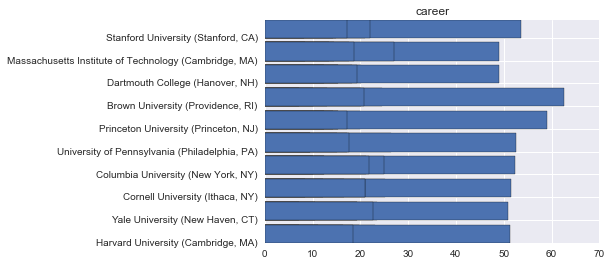

In [272]:
for topic in topics:
    plt.barh(range(len(df_topicschool)), df_topicschool[topic], tick_label=df_topicschool.index)
    plt.title(topic)

#### Histogram of Topics

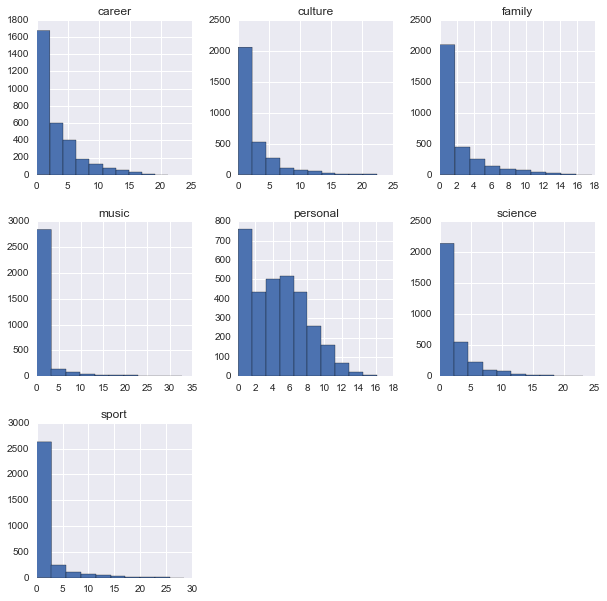

In [43]:
_=(df_et.ix[:,2:].astype(float)*100).hist(figsize=(10,10))

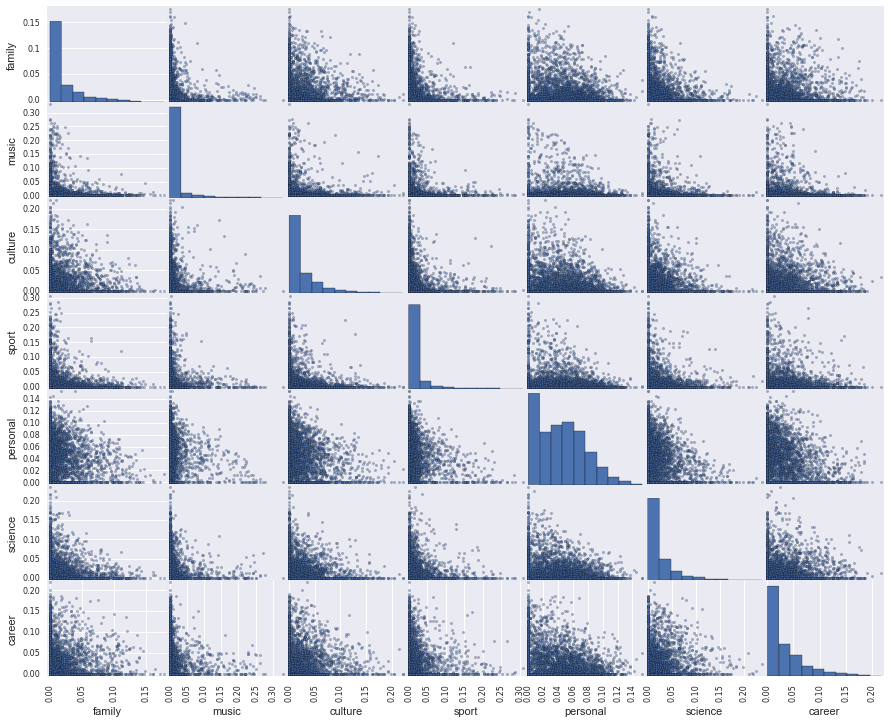

In [170]:
_=pd.scatter_matrix(df_et.ix[:,1:].astype(float), figsize=(15,12))

### Export Tfidf Matrix (for recommending essays)

In [124]:
with open('../data/tfidf_mat.pkl', 'w') as f:
    pickle.dump(mat, f)

### Recommend Similar Essays

In [135]:
reload(ea)
tm = ea.TopicModeling()

In [136]:
# essays[10]

In [142]:
# tm.similarEssaysNMF(essays[10], essays, W, vec, nmf)

In [139]:
# tm.similarEssaysTfidf(essays[10], essays, mat, vec)

### Latent Dirichlet Allocation (LDA)

In [253]:
count_vec = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=10000)
count_mat = count_vec.fit_transform(X)

In [254]:
count_mat

<3177x10000 sparse matrix of type '<type 'numpy.int64'>'
	with 582653 stored elements in Compressed Sparse Row format>

In [255]:
lda = LatentDirichletAllocation(n_topics=7)
lda.fit(count_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=7, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [59]:
W_lda = lda.transform(count_mat)

In [60]:
H_lda = lda.components_
tm.showTopWords(H_lda, count_vec, 40)

[array([u'comput', u'math', u'scienc', u'class', u'problem', u'program',
        u'student', u'technolog', u'mr', u'book', u'teacher', u'read',
        u'solv', u'mathemat', u'tutor', u'game', u'calculu', u'code',
        u'physic', u'ap', u'teach', u'test', u'use', u'harri', u'chemistri',
        u'websit', u'number', u'lab', u'solut', u'engin', u'grade', u'ms',
        u'build', u'cours', u'potter', u'sit', u'id', u'genet', u'applic',
        u'learn'], 
       dtype='<U17'),
 array([u'refere', u'unicycl', u'crane', u'nai', u'pluto', u'acr',
        u'jonathan', u'chin', u'younglif', u'carniv', u'babson',
        u'misadventur', u'bust', u'rosa', u'batman', u'obo', u'katherin',
        u'rockaway', u'lamb', u'lamin', u'baton', u'holm', u'owen',
        u'livingston', u'troy', u'editor', u'sherlock', u'barbado',
        u'dakota', u'joel', u'soybean', u'ashevil', u'lineman',
        u'cannonbal', u'digest', u'wang', u'handbal', u'traitor', u'87',
        u'assay'], 
       dtype='<U17